# Build an efficient unsupervised word translator

Based on : "Word Translation Without Parallel Data" by Alexis Conneau, Guillaume Lample, Marc Aurelio Ranzato, Ludovic Denoyer & Hervé Jégou (2017)

In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.stats import special_ortho_group
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
##########
eng_path = '/Users/louismonier/Downloads/Monolingual/wiki.en.vec' 
fr_path = '/Users/louismonier/Downloads/Monolingual/wiki.fr.vec'
##########
#eng_path = '/Users/vince/DataProjetNLP/wiki.en.vec'
#fr_path = '/Users/vince/DataProjetNLP/wiki.fr.vec'
##########
nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

In [4]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [5]:
# train & test bilingual dictionaries
##########
path_train = r'/Users/louismonier/Downloads/Monolingual/fr-en.0-5000.txt' 
path_test = r'/Users/louismonier/Downloads/Monolingual/fr-en.5000-6500.txt'
##########
#path_train = '/Users/vince/DataProjetNLP/fr-en.0-5000.txt' 
#path_test = '/Users/vince/DataProjetNLP/fr-en.5000-6500.txt'
##########

dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test)

# convert embeddings vectors into torch tensors 
print(type(X_train[0]))
X_train, Z_train, X_test, Z_test = map(torch.tensor, (X_train, Z_train, X_test, Z_test)) 
print(type(X_train[0]))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [6]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")
dim = X_train.shape[1]
print("Vectors dimension :", dim)

4971 training samples
1483 test samples
Vectors dimension : 300


## Build the discriminator 

Recall what is the objective of the discriminator here : ...

In [7]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator,self).__init__()
        self.h1 = nn.Linear(dim, 2048,bias=True) # 1st hidden layer
        #self.h2 = nn.Linear(2048,2048,bias=True) # 2nd hidden layer
        self.out = nn.Linear(2048,1,bias=True) # output layer
        
    def forward(self, x):
        x = F.dropout(x, p = 0.1) # dropout pour ajouter du bruit
        x = F.leaky_relu(self.h1(x)) #, negative_slope=0.2)
        #x = F.leaky_relu(self.h2(x), negative_slope=0.2)
        y = torch.sigmoid(self.out(x)) # ouput = proba
        return y

## Build the generator 

Recall what is the objective of the discriminator here : ...

In [8]:
# simple linear function 
# can be seen at a neural network whose weights are elements of W 
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(dim, dim, bias=False)

    def forward(self,x):
        y = self.l1(x)
        return y

## It's time to train 

In [9]:
discrim = Discriminator(dim)
gener = Generator(dim)

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

optimizerD = optim.SGD(discrim.parameters(), lr=0.1)
optimizerG = optim.SGD(gener.parameters(), lr=0.1)

In [11]:
#for epoch in range(3): #3 Epochs 
G_losses = []
D_losses = []
iters = 0

N = 16 # nb of "fake" tgt // Wx
M = 16 # nb of "true" tgt // y

W = special_ortho_group.rvs(dim) #np.zeros((300,300), dtype=float)  #np.random.rand(Z_train.shape[1],Z_train.shape[1]) #  # #
gener.l1.weight.data = torch.tensor(W,dtype=torch.float) # ini of generator's weights in SO(300)
beta = 0.01

for param in discrim.h1.parameters():
    param.data.normal_(0.0, 0.2) #uniform_(-0.1,0.1)

niter = 1000
num_epochs = 5
#nb_d = 1
#nb_g = 10

# Establish convention for real and fake labels during training
real_label = 0.8
fake_label = 0.2

In [13]:
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(niter):
        
        ###############################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###############################################################
        
        ## Train with all-real batch
        discrim.zero_grad()
        # Format batch : generate M random words from the target
        
        rand_tgt_word_id = torch.Tensor(M).random_(X_train.shape[0]).long()
        tgt_word_emb = Z_train[rand_tgt_word_id.numpy()]
        tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor

        label = torch.full((M,1), real_label)
        
        # Forward pass real batch through D
        output = discrim(tgt_word_emb)#.view(-1)
        #print(output.shape)
        #print(output.view(-1).shape)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        ## create a new batch of N fake & M true data to train the discriminator
        # generate N random words from the source 
        rand_src_word_id = torch.Tensor(N).random_(X_train.shape[0]).long()
        src_word_emb = X_train[rand_src_word_id.numpy()]
        noise = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor
        
        # Generate fake tgt batch with G
        fake = gener(noise)
        
        label.fill_(fake_label)  
        # Classify all fake batch with D
        output = discrim(fake.detach())#.view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gener.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discrim(fake)#.view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        W_trained = gener.l1.weight.data # get the weights of the generator which are the elements of W
        # to ensure that the matrix stays close to the manifold of orthogonal matrices after each update
        W_ortho = (1+beta)*W_trained - beta*torch.mm(torch.mm(W_trained, W_trained.t()), W_trained) 
        gener.l1.weight.data = W_ortho 
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, niter,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[0/5][0/1000]	Loss_D: 1.4459	Loss_G: 2.1406	D(x): 0.4791	D(G(z)): 0.5109 / 0.0819


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0/5][50/1000]	Loss_D: 16.3349	Loss_G: 7.8043	D(x): 0.9998	D(G(z)): 1.0000 / 0.0040
[0/5][100/1000]	Loss_D: 8.1192	Loss_G: 6.6719	D(x): 0.9931	D(G(z)): 0.9996 / 0.0006
[0/5][150/1000]	Loss_D: 5.3676	Loss_G: 5.4549	D(x): 0.9361	D(G(z)): 0.9917 / 0.0021
[0/5][200/1000]	Loss_D: 3.4546	Loss_G: 3.1207	D(x): 0.8264	D(G(z)): 0.9551 / 0.0299
[0/5][250/1000]	Loss_D: 3.3459	Loss_G: 0.7574	D(x): 0.0527	D(G(z)): 0.1685 / 0.9444
[0/5][300/1000]	Loss_D: 3.3985	Loss_G: 0.7100	D(x): 0.0599	D(G(z)): 0.2277 / 0.9172
[0/5][350/1000]	Loss_D: 2.2197	Loss_G: 0.5495	D(x): 0.2185	D(G(z)): 0.3511 / 0.8380
[0/5][400/1000]	Loss_D: 2.2148	Loss_G: 0.5602	D(x): 0.2355	D(G(z)): 0.4728 / 0.6748
[0/5][450/1000]	Loss_D: 1.9373	Loss_G: 0.5358	D(x): 0.2455	D(G(z)): 0.3090 / 0.7295
[0/5][500/1000]	Loss_D: 1.6291	Loss_G: 1.9228	D(x): 0.7072	D(G(z)): 0.6858 / 0.1394
[0/5][550/1000]	Loss_D: 1.8072	Loss_G: 2.4322	D(x): 0.5981	D(G(z)): 0.7374 / 0.0683
[0/5][600/1000]	Loss_D: 1.9643	Loss_G: 2.3997	D(x): 0.6289	D(G(z)): 0.7793 /

[4/5][950/1000]	Loss_D: 1.4325	Loss_G: 0.7975	D(x): 0.5545	D(G(z)): 0.5624 / 0.4368


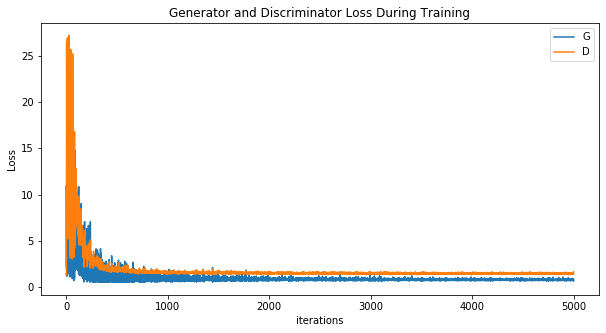

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Tests

In [16]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # embedding on of new_word in the source space
    z = np.dot(W, x) # embedding of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300), tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300), tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [17]:
W_trained_test = gener.l1.weight.data
print(W_trained_test[:3,:3])

tensor([[ 0.0372,  0.0441,  0.0013],
        [-0.0288,  0.0582, -0.0241],
        [-0.0095, -0.1309,  0.0246]])


In [18]:
# just a litte test
top1, top5 = prediction(W_trained_test, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['ever']
Top 5 translations for 'bateau' are : ['ever', 'champions', 'technologically', 'championship', 'materially']


In [19]:
src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_trained_test.numpy(), src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])
    print(top5)
    print('--')

['ever', 'champions', 'technologically', 'championship', 'materially']
--
['loggins', 'brecker', 'flanagan', 'kelly', 'brubeck']
--
['methodist', 'promptly', 'carl', 'methodism', 'likewise']
--
['annoy', 'so', 'piss', 'hurting', 'therefore']
--
['glad', 'regret', 'adamant', 'commented', 'terrific']
--


In [ ]:
# 2 possibles functions of accuracy = 
# - Test if we traduced well the word = sum Indicatrice(Wxi!=zi) (en gros nb de mots mal traduits) # en fait non c'est con on a pas les traductions
# - Test how far we are from the "supposed" translation
# compute Wxi find the closest z (SUPPOSED TO BE ITS TRANSLATION) and cumpute eculidian distance
def test_accuracy(X_text,W_trained):
    loss = 0
    for x in X_test : # get all french words
        word2id = {v: k for k, v in src_id2word.items()}
        word_emb_new = np.dot(W_trained, x)
        scores = (tgt_embeddings / np.linalg.norm(tgt_embeddings, 2, 1)[:, None]).dot(word_emb_new / np.linalg.norm(word_emb_new))
        best = scores.argsort()[-1:][::-1]
        nearest_eng_emb = src_embeddings[best]
        loss = loss + np.linalg.norm(word_emb_new-nearest_eng_emb)  
    return(loss)
    
# Pous savoir si le model est pertinent tester l'accuracy pour W_trained a epoch 1,5,10                             

In [ ]:
rand_test_word_id = torch.Tensor(30).random_(nmax).long()
X_test = src_embeddings[rand_test_word_id.numpy()] # GARDER LES MEMES POUR LES TESTS

test_accuracy(X_test,W_trained_test)

In [ ]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, k):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [ ]:
# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_trained_test, k) 

In [ ]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [ ]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)

In [ ]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

## How to pair words

CSLS tentative

In [ ]:
k = 5 # hyper parameter K-NN
CSLS = np.zeros(nmax)

def CSLS_measure(W, new_word, k):
    x = src_embeddings[src_word2id[new_word]] # embeddings of new_word in the source space
    z = np.dot(W, x).reshape(-1,300) # embeddings of the translated word in the target space
    
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    for t in range(tgt_embeddings.shape[0]):
        dist_tgt_nn_z, index_tgt_nn_z = knn.kneighbors(z)
        emb_tgt_nn_z = tgt_embeddings[index_tgt_nn_z[0][:]].reshape(-1,300) # embeddings of the k-nn in the tgt space
        r_T = (1/k)*sum(cosine_similarity(z, emb_tgt_nn_z))
        
        dist_tgt_nn_yt, index_tgt_nn_yt = knn.kneighbors(tgt_embeddings[t])
        emb_tgt_nn_yt = tgt_embeddings[index_tgt_nn_yt[0][:]].reshape(-1,300) 
        r_S = (1/k)*sum(cosine_similarity(tgt_embeddings[t], emb_tgt_nn_yt))
        
        CSLS[t] = 2*cosine_similarity(z, tgt_embeddings[t]) - r_T - r_S
    CSLS = np.argmax(CSLS)
        
    return CSLS